In [1]:
# %matplotlib notebook
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression

# Classification

In previous lectures we looked at the way we can use distributions to describe data, as well as for identifying inherent clustering/organisation within the properties of the data available. We can think of this approach as the <b>unsupervised classification</b> of data. If, however, we have labels for some of these data points (e.g., an object is tall, short, red, or blue) we can utilize this information to develop a relationship between the label and the properties of a source. We refer to this as <b>supervised classification</b>.

Though we technically did not build an actual classifier, we saw how distributions of data could provide a probabilistic basis for which a male/female voice classifier could be built. The difference in range of pitch values across speakers could be used to build such a classifier, so long as we find the right <b>classification boundary</b> between these two distributions. 

The motivation for supervised classification comes from the long history of classification in speech technology - as one of the foremost applications of machine learning techniques for a long number of years. Classification lies at the foundation of almost anything you will be doing in speech, not just this unit, but if you choose to work in the field later on. The good thing about most of what you shall learn in this unit applies to a much wider set of problems in speech technology. Whether you want to classify one speaker trait or another, or whether you need to build a classification framework for speech recognition etc.

The hard part is not about determining that many problemsin speech boil down to a classical classification problem, but rather learning the art of picking an appropriate classification methodology for a problem, or indeed creating a whole new classification algorithm (we will not be doing this for LIN3503).

## Assigning Categories
Supervised classification takes a set of features and relates them to predefined sets of classes. We will not address how we define the labels or taxonomy for the classification other than noting that the time-honored system of having a graduate student label data does not scale to the size of today’s data. We start by assuming that we have a set of predetermined labels that have been assigned to a subset of the data we are considering. Our goal is to characterize the relation between the features in the data and their classes (<b>machine learning</b>) and apply these classifications to a larger set of unlabeled data (<b>inference</b>).

As we go we will illuminate the connections between classification, regression, and density estimation. Classification can be posed in terms of density estimation - this is called <b>generative classification</b> (so-called since we will have a full model of the density for each class, which is the same as saying we have a model which describes how data could be generated from each class). This will be our starting point, where we will visit a number of methods. Among the advantages of this approach is a high degree of interpretability.

Starting from the same principles we will go to classification methods that focus on finding the decision boundary that separates classes directly, avoiding the step of modeling each class’s density, called discriminative classification, which can often be better in high-dimensional problems.

## Classification Loss
Perhaps the most common loss (cost) function in classification is zero-one loss, where we assign a value of one for misclassification and zero for a correct classification. One particularly common case of classification in that of "verification", where we wish to assign objects (i.e., samples of speech) into one of two classes: a detection, say of a person trying to use a HomePod (usually with label 1) and a nondetection (usually with label 0). When thinking about this sort of problem, we may wish to distinguish between the two possible kinds of error: assigning a label 1 to an object whose true class is 0 (a “false positive”), and assigning the label 0 to an object whose true class is 1 (a “false negative”).

Based on loss metrics such as the above, we can define two measures which will help us to determine how well our classifiers work. The first measure is <b>completeness</b>:
\begin{equation}
\text{completeness} = \frac{\text{true positives}}{\text{true positives}+\text{false negatives}}
\end{equation}

The second measure is <b>contamination</b>:
\begin{equation}
\text{contamination} = \frac{\text{false positives}}{\text{true positives}+\text{false negatives}}
\end{equation}

The completeness measures the fraction of total detections identified by our classifier, while the contamination measures the fraction of detected objects which are misclassified. Depending on the nature of the problem and the goal of the classification, we may wish to optimize one or the other.

Alternative names for these measures abound: in some fields the completeness and contamination are respectively referred to as the "sensitivity" and the "Type I error". In some literature, one minus the contamination is often referred to as the "efficiency". In purist machine learning communities, the efficiency and completeness are respectively referred to as the "precision" and "recall". Furthermore, the concept of precision and recall can be extended to problems with multiple classes (not just zero-one loss).

# Naive Bayes Classification
Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very <b>high-dimensional</b> datasets. Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem.

Naive Bayes classifiers are built on Bayesian classification methods. These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities. In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L|\text{features})$. Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

\begin{equation}
P(L|\text{features}) = \frac{P(\text{features}|L)P(L)}{P(\text{features})}
\end{equation}

If we are trying to decide between two labels - let's call them L1
 and L2 - then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

\begin{equation}
\frac{P(L_1|\text{features})}{P(L_2|\text{features})} = \frac{P(\text{features}|L_1)}{P(\text{features}|L_2)} \frac{P(L_1)}{P(L_2)}
\end{equation}

All we need now is some model by which we can compute $P(\text{features}| L_i)$ for each label. Such a model is called a generative model because it specifies the hypothetical random process that generates the data. Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier. The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification. Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine a few of these in the following sections.

## Gaussian Naive Bayes
Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes. In this classifier, the assumption is that data from each label is drawn from a simple Gaussian distribution. Imagine that you have the following data:

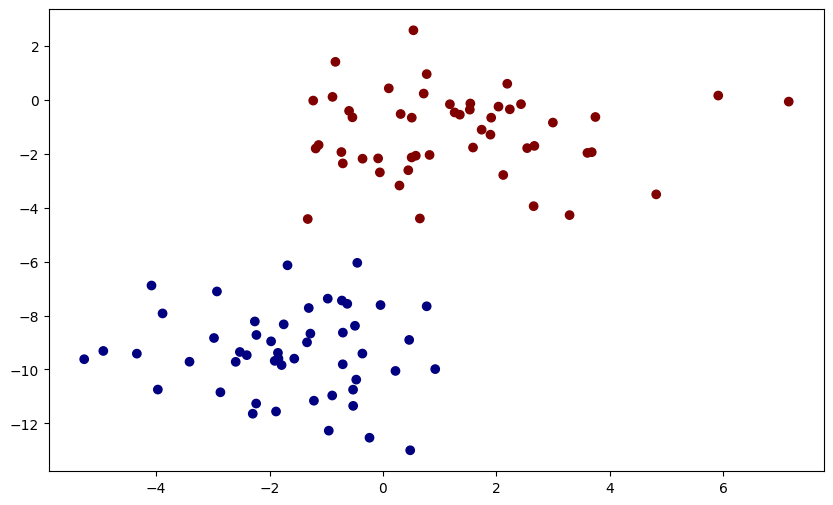

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
fig, ax0 = plt.subplots(figsize=(10, 6))
ax0.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.jet)
plt.show()

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions. This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution. The result of this naive Gaussian assumption is shown in the following figure:

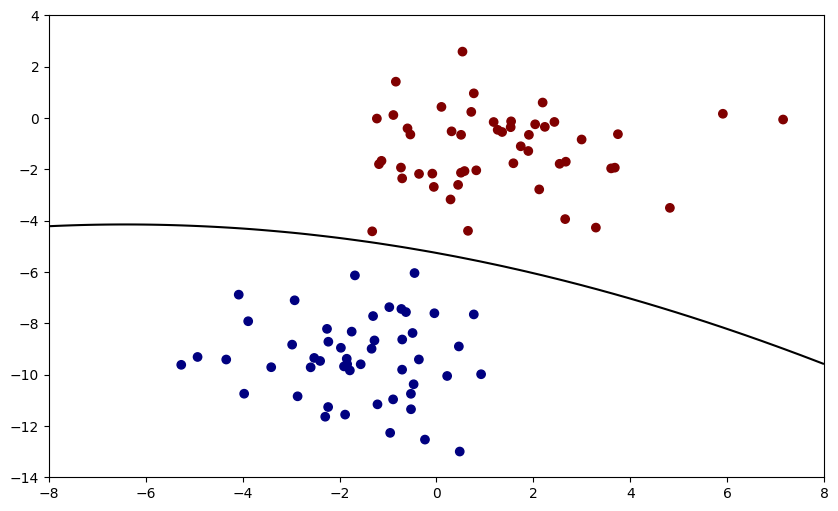

In [3]:
# Fit the Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X, y)

# predict the classification probabilities on a grid
xlim = (-8, 8)
ylim = (-14, 4)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
#convert to 1-D arrays
oned_xx = xx.ravel()
oned_yy = yy.ravel()

# get probabilities of each x,y coordinate from the NB classifier
# i.e. returns the probability of the samples for each class in the model. 
Z = gnb.predict_proba(np.column_stack((oned_xx,oned_yy)))
Z = Z[:, 1].reshape(xx.shape)
# Plot the samples again
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm.jet)

# Now plot the contour between the two classes at p=0.5
# i.e. for every coordinate in xx,yy, if z is at 0.5 
# (equal probability) of both classes,
# then draw the contour at that coordinate
ax.contour(xx, yy, Z, [0.5], colors='k')
plt.show()

The assumption has generated a multivariate (2-D) Gaussian for each class. Towards the denser center of each class, the probability is higher, and falls the further we vary from the center. This normal distribution is done for both classes, and there is a point (the black line) where a sample could be generated from any of the two classes with equal probability.

When we utilized the 'gnb.predict_proba()' method of the Gaussian Naive Bayes classifier, the returned columns give the posterior probabilities of the first and second label, respectively. Since we measured a probability over an entire grid of possible samples, we have a map of probabilities for each class, at each point in the image. This information was used to draw the black contour delineating the point at which there is equal probabilitiy for each class to generate a sample along the contour.

### Gaussian Naive Bayes for Male/Female Voice Classification
The Gaussian Naive Bayes classification we have considered so far was performed on a simple, well-separated data set. Examples like this one make classification straightforward, but data in the real world is rarely so clean. Instead, the distributions often overlap, and categories have hugely imbalanced numbers. To demonstrate this, we shall be applying Gaussian Naive Bayes classification to a Male-Female voice data set.

As an initial exampe we shall just look into the voice of two speakers only - you can expect overlap to be present, but this only gets worse as the speaker population increases. The variety of voice characteristics is always a problem in speech processing in general - so keep this in mind when working with future data. We have previously looked at pitch values for this type of classification. However, now that we have covered one of the most standard forms of feature extraction methods in speech systems (MFCCs) in a previous lecture, we shall see how these features can be employed here:


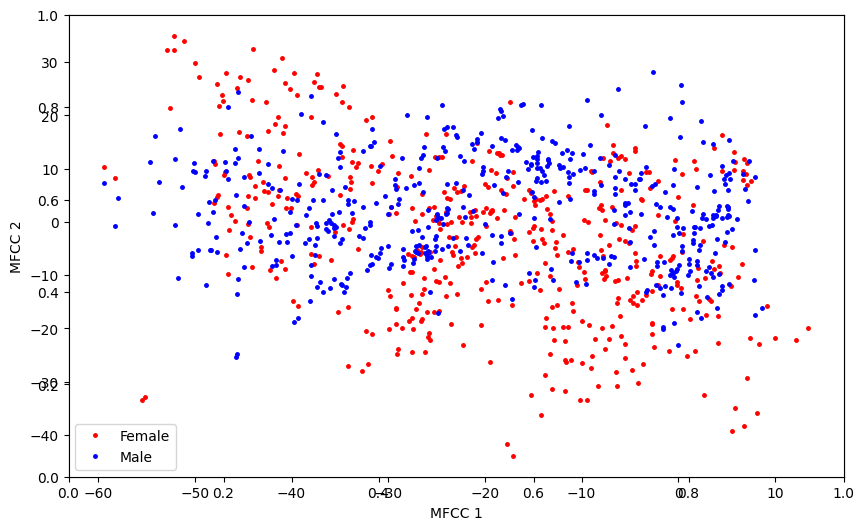

In [4]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np

(rate,sig) = wav.read('./data/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
mfcc_feat_female = mfcc_feat_female[0:500,:] # first 500 points
mfcc_feat_female_2d = mfcc_feat_female[0:500,1:3] # first 2 dimensions

(rate,sig) = wav.read('./data/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
mfcc_feat_male = mfcc_feat_male[0:500,:] # first 500 points
mfcc_feat_male_2d = mfcc_feat_male[0:500,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

# plot the results
fig, ax_data = plt.subplots(figsize=(10, 6))
ax_data = plt.axes()
ax_data.plot(samples_2d[(labels==0),0], samples_2d[(labels==0),1], '.', ms=5, c='r', label='Female')
ax_data.plot(samples_2d[(labels==1),0], samples_2d[(labels==1),1], '.', ms=5, c='b', label='Male')

ax_data.legend(loc=3)
ax_data.set_xlabel('MFCC 1')
ax_data.set_ylabel('MFCC 2')

plt.show()

In the figure above, the blue samples show the first 2 MFCC dimensions for a male voice, while the red points show data for a female voice. We are only plotting two features for each sample, i.e. MFCC 1 vs. MFCC 2. There are of course 13 features for the dataset (standard MFCC extraction). In general, you would build classifiers over the entire set of dimensions. But for illustrative purposes, let us try out Gaussian Naive Bayes classification to this highly overlapping dataset:

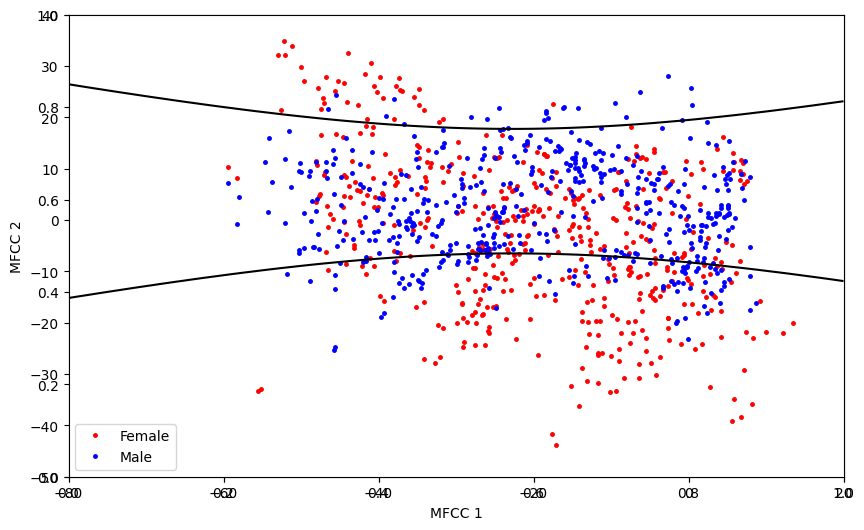

In [5]:
# Fit the Naive Bayes classifier to the first 2 dimensions
gnb = GaussianNB()
gnb.fit(samples_2d, labels)

# predict the classification probabilities on a grid
xlim = (-80, 20)
ylim = (-50, 40)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))

#convert to 1-D arrays
oned_xx = xx.ravel()
oned_yy = yy.ravel()

# get probabilities of each x,y coordinate from the NB classifier
# i.e. returns the probability of the samples for each class in the model. 
Z = gnb.predict_proba(np.column_stack((oned_xx,oned_yy)))
Z = Z[:, 1].reshape(xx.shape)

# Plot the samples again
fig, ax_gnb = plt.subplots(figsize=(10, 6))
ax_gnb = plt.axes()
ax_gnb.plot(samples_2d[(labels==0),0], samples_2d[(labels==0),1], '.', ms=5, c='r', label='Female')
ax_gnb.plot(samples_2d[(labels==1),0], samples_2d[(labels==1),1], '.', ms=5, c='b', label='Male')

ax_gnb.legend(loc=3)
ax_gnb.set_xlabel('MFCC 1')
ax_gnb.set_ylabel('MFCC 2')

# Now plot the contour between the two classes at p=0.5
# i.e. for every coordinate in xx,yy, if z is at 0.5 
# (equal probability) of both classes, then draw the contour at that coordinate
ax_gnb.contour(xx, yy, Z, [0.5], colors='k')

plt.show()

The classification boundary is unable to separate regions of high overlap between the two categories, but it gives the best possible separation based on the generative model employed - a multivariate Gaussian distribution.

We can now look at the predictions (classifications) of the data that was used to train the model, and analyze it via the criteria of completeness and contamination. For this purpose, we will retrain the model to employ multivariate Gaussians covering all dimensions in the dataset:

In [6]:
# Fit the Naive Bayes classifier to all original dimensions
gnb = GaussianNB()
gnb.fit(samples, labels)

# now predict
labels_pred = gnb.predict(samples)

#get completeness score (equivalent to recall)
completeness_score = recall_score(labels,labels_pred)
#get contamination score (equivalent to 1-precision)
contamination_score = (1-precision_score(labels,labels_pred))

print('Completeness: %f'%completeness_score)
print('Contamination: %f'%contamination_score)

Completeness: 0.890000
Contamination: 0.275244


### Gaussian Naive Bayes Recap
This section introduced the concept of Naive Bayes classification, based on Gaussian models. Of course, any model that provides predictions for a sample can be used in this framework - it need not be Gaussian. We have also introduced and demonstrated a number of classification concepts which will be useful for other classification methods.

As a rule of thumb, when should you be inclined to use Naive Bayes classification? Keep in mind that you are making stringent assumptions about the data based on the particular model of choice. That being said, Naive Bayes classifiers have a number of advantages:
* They are extremely fast for both training and prediction
* They provide straightforward probabilistic prediction
* They are often very easy to interpret
* They have very few (if any) parameters that need tuning

These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification. If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem. If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:
* When the naive assumptions actually match the data (very rare in practice)
* For very well-separated categories, when model complexity is less important
* For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: as the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in every single dimension to be close overall). This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information. For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.

## Linear and Quadratic Discriminant Analysis
Linear Discriminant Analysis (LDA), like Gaussian Naive Bayes, relies on some simplifying assumptions about the class distribution. In particular, it assumes that these distributions have identical covariances for all the K classes. This makes all classes a set of shifted Gaussians.

The optimal classifier can then be derived from the log of the class posteriors to be:

\begin{equation}
g_k(x) = x^T\Sigma^{-1}\mu_{k} - \frac{1}{2}\mu_{k}^T\Sigma^{-1} + log\pi_k
\end{equation}

With $\mu_{k}$ as the mean of class $k$, and $\Sigma$ the covariance of the Gaussians (shared across all classes). The class dependent covariancs that would normally give rise to a quadratic dependence on $x$, cancel out if they are assumed to be constant. The Bayes cassifier is, therefore, linear with respect to $x$.

The discriminant boundary between the classes, is going to be linear. There is a discriminant boundary between each pair of classes in the dataset. The minimized overlap between the two Gaussians that define the pair of classes is given as:

\begin{equation}
g_k(x) - g_l(x) = x^T\Sigma^{-1}(\mu_{k}-\mu_{l}) - \frac{1}{2}(\mu_{k}-\mu_{l})^T\Sigma^{-1}(\mu_{k}-\mu_{l}) + log\left(\frac{\pi_k}{\pi_l}\right) = 0
\end{equation}

If we were to relax the requirement that the covariances of the Gaussians are constant, the discriminant function for the classes becomes quadratic in $x$:

\begin{equation}
g_k(x) = -\frac{1}{2}log|\Sigma_{k}|-\frac{1}{2}(x-\mu_k)^TC^{-1}(x-\mu_k)+log\pi_{k}
\end{equation}

This is sometimes known as Quadratic Discriminant Analysis (QDA), and the boundary between classes is described by a quadratic function of the features x. In Python, we can utilize LDA/QDA classifiers for the same Male/Female voice problem we had earlier like so:

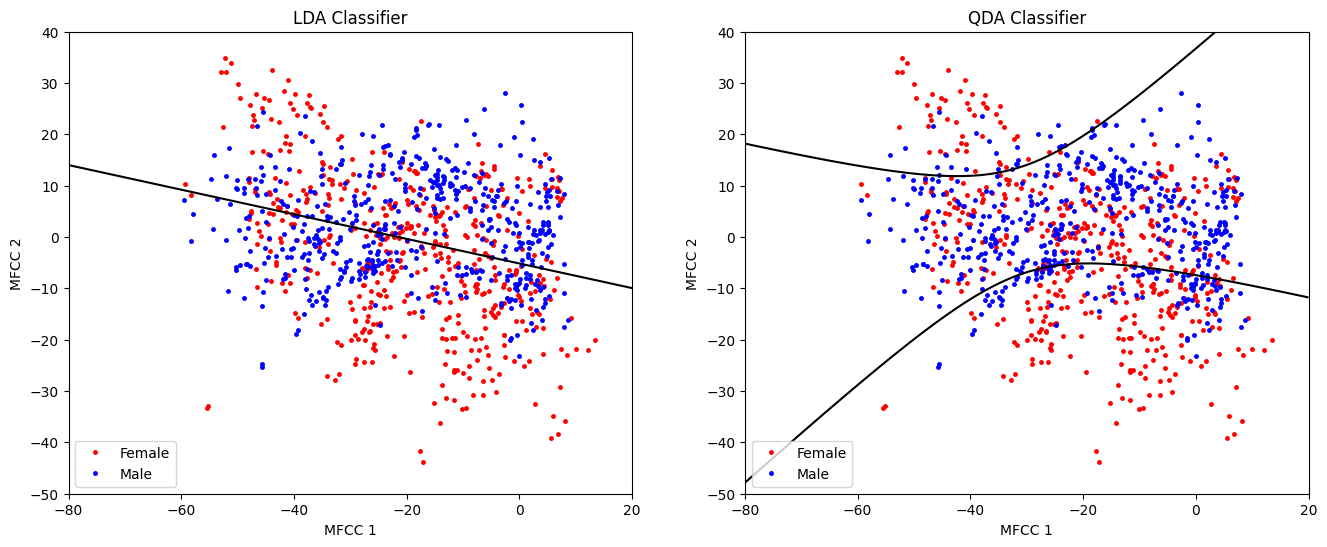

In [7]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np

(rate,sig) = wav.read('./data/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
mfcc_feat_female = mfcc_feat_female[0:500,:] # first 500 points
mfcc_feat_female_2d = mfcc_feat_female[0:500,1:3] # first 2 dimensions

(rate,sig) = wav.read('./data/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
mfcc_feat_male = mfcc_feat_male[0:500,:] # first 500 points
mfcc_feat_male_2d = mfcc_feat_male[0:500,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

# fit an LDA classifier and get predictions
lda = LDA()
lda.fit(samples_2d, labels)
lda_labels_pred = lda.predict(samples_2d)

# fit a QDA classifier and get predictions
qda = QDA()
qda.fit(samples_2d, labels)
qda_labels_pred = qda.predict(samples_2d)

# Create 2 subplots to view LDA/QDA together
f, (ax_lda, ax_qda) = plt.subplots(1, 2, figsize=(16, 6))

# predict the LDA classification probabilities on a grid (we've seen this before)
xlim = (-80, 20)
ylim = (-50, 40)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
oned_xx = xx.ravel()
oned_yy = yy.ravel()
Z = lda.predict_proba(np.column_stack((oned_xx,oned_yy)))
Z = Z[:, 1].reshape(xx.shape)
ax_lda.plot(samples_2d[(labels==0),0], samples_2d[(labels==0),1], '.', ms=5, c='r', label='Female')
ax_lda.plot(samples_2d[(labels==1),0], samples_2d[(labels==1),1], '.', ms=5, c='b', label='Male')
ax_lda.legend(loc=3)
ax_lda.set_xlabel('MFCC 1')
ax_lda.set_ylabel('MFCC 2')
ax_lda.set_title('LDA Classifier')
ax_lda.contour(xx, yy, Z, [0.5], colors='k')

# predict the QDA classification probabilities on a grid (we've seen this before)
xlim = (-80, 20)
ylim = (-50, 40)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
oned_xx = xx.ravel()
oned_yy = yy.ravel()
Z = qda.predict_proba(np.column_stack((oned_xx,oned_yy)))
Z = Z[:, 1].reshape(xx.shape)
ax_qda.plot(samples_2d[(labels==0),0], samples_2d[(labels==0),1], '.', ms=5, c='r', label='Female')
ax_qda.plot(samples_2d[(labels==1),0], samples_2d[(labels==1),1], '.', ms=5, c='b', label='Male')
ax_qda.legend(loc=3)
ax_qda.set_xlabel('MFCC 1')
ax_qda.set_ylabel('MFCC 2')
ax_qda.set_title('QDA Classifier')
ax_qda.contour(xx, yy, Z, [0.5], colors='k')

plt.show()

The results of LDA and QDA show, true to their names, a linear boundary between the two classes for LDA, while QDA results in a quadratic boundary. As may be expected with a more sophisticated model, QDA yields improved completeness and contamination in comparison to LDA. Also, recall what assumptions were made to generate a QDA classifier. We relaxed the original LDA requirement that the covariances of the Gaussians are constant. What happens is that the two classes are defined by two different Gaussians. Is that not also the way the Gaussian Naive Bayes classifier was built? Indeed, QDA and Gaussian Naive Bayes would be equivalent if we further constrain $\Sigma$ to be a diagonal covariance matrix - something we do not force for QDA, but generally do for Gaussian Naive Bayes.

I am sure you are curious on how well these classifiers perform compared to Gaussian Naive Bayes. Let us check them out:

In [8]:
# Fit the LDA classifier to all original dimensions
lda = LDA()
lda.fit(samples, labels)
lda_labels_pred = lda.predict(samples)

# get LDA scores
completeness_score = recall_score(labels,lda_labels_pred)
contamination_score = (1-precision_score(labels,lda_labels_pred))
print('LDA')
print('Completeness: %f'%completeness_score)
print('Contamination: %f'%contamination_score)


# Fit the QDA classifier to all original dimensions
qda = QDA()
qda.fit(samples, labels)
qda_labels_pred = qda.predict(samples)

#get QDA scores
completeness_score = recall_score(labels,qda_labels_pred)
contamination_score = (1-precision_score(labels,qda_labels_pred))
print('QDA')
print('Completeness: %f'%completeness_score)
print('Contamination: %f'%contamination_score)

LDA
Completeness: 0.818000
Contamination: 0.147917
QDA
Completeness: 0.922000
Contamination: 0.126894


# Discriminative Classification
With the classifiers we looked at so far, the idea was focused on analyzing the data for each particular class, and to find some distribution that characterises the data for the class well, whilst providing low probabilities to samples from other classes. We termed this form of classification as <b>generative</b> classification, as the end result is a distribution that could generate samples similar to the actual data used to model it in the first place. This inadvertently results in a cross over in the data space where the distributions for both classes give the same probability for a particular data point. We delineated this contour in the examples so far.

Another form of classification is <b>discriminative</b> classification where the class density estimates are skipped in favour of a classification decision boundary. We therefore do not tie the boundary by assumptions about the distribution of the data.

## Logistic Regression
Logistic regression is a predictive modelling algorithm that is used when the class variable ($Y$) is binary categorical. That is, it can take only two values like 1 or 0. The goal is to determine a mathematical equation that can be used to predict the probability of event 1. Once the equation is established, it can be used to predict the class when only the sample points ($X$’s) are known.

Earlier we saw what is linear regression and how to use it to predict continuous $Y$ variables for an input $X$. In linear regression the $Y$ variable is always a continuous variable. If suppose, the $Y$ variable was categorical, you cannot use linear regression to model it. So what would you do when the $Y$ is a categorical variable with 2 classes - besides the methods we discussed for generative classification?

Logistic regression is a discriminative classifier that can be used to model and solve such problems, also called as binary classification problems. A key point to note here is that $Y$ can have 2 classes only and not more than that. If $Y$ has more than 2 classes, it would become a multi-class classification and you can no longer use the vanilla logistic regression for that. You would have to build a "one-versus-all" type binary classifier for every class in the dataset, reducing the problem to multiple binary classifiers.

Even so, logistic regression is a classic predictive modelling technique and still remains a popular choice for modelling binary categorical variables. Another advantage of logistic regression is that it computes a prediction probability score of an event. More on that as we start building the models.

The example we have considered so far (Male vs Female classification), is a binary classification task for which logistic regression is suitable. So let us get down to visualzing the main difference between the concept of linear regression and logistic regression.

<img src="./figures/linear_vs_logistic_regression.png" width="800">

When the response variable $Y$ has only 2 possible values, it is desirable to have a model that predicts the value either as 0 or 1 or as a probability score that ranges between 0 and 1. Linear regression does not have this capability. Because, if you use linear regression to model a binary response variable, the resulting model may not restrict the predicted $Y$ values within 0 and 1.

This is where logistic regression comes into play. In logistic regression, you get a probability score that reflects the probability of the occurence of the event. An event in this case is each sample of the training dataset. It could be something like classifying if a given value in a formant space belonging to a male voice or not.

Logistic regression achieves this by taking the log odds of the event $ln(P/1−P)$, where, $P$ is the probability of an event/sample. So $P$ always lies between 0 and 1. The logistic regression formulation is:

\begin{equation}
p(y=1|x) = \frac{\text{exp} \left[\sum_j \theta_j x^j\right]}{1 + \text{exp} \left[\sum_j \theta_j x^j\right]}
\end{equation}

where the logistic function (logit) is defined as:
\begin{equation}
\text{logit}(p_i) = \log \left(\frac{p_i}{1-p_i}\right) = \sum_j \theta_j x_{i}^{j}
\end{equation}

The name logistic regression comes from the fact that the function $e^x/(1+e^x)$ is called the logistic (or sigmoid) function. Its name is due to its roots in regression, even though it is a method for classification.

Let us look at how logistic regression performs on our sample dataset:

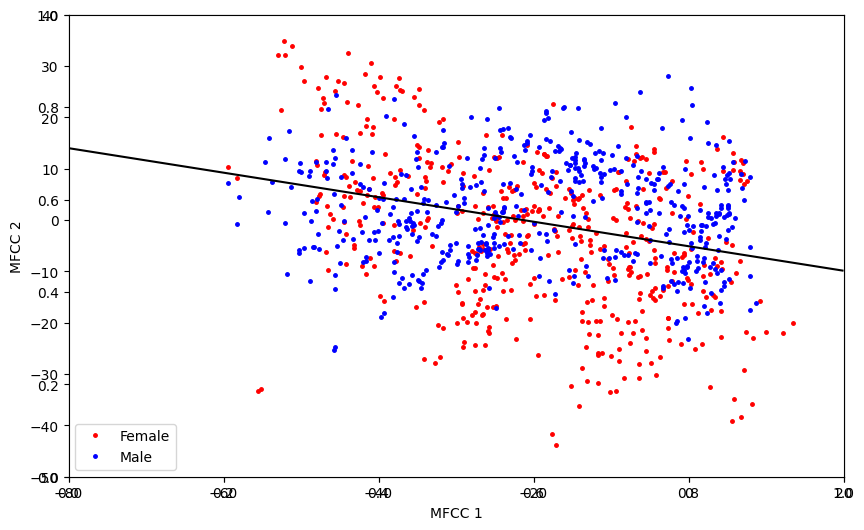

In [9]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np

(rate,sig) = wav.read('./data/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
mfcc_feat_female = mfcc_feat_female[0:500,:] # first 500 points
mfcc_feat_female_2d = mfcc_feat_female[0:500,1:3] # first 2 dimensions

(rate,sig) = wav.read('./data/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
mfcc_feat_male = mfcc_feat_male[0:500,:] # first 500 points
mfcc_feat_male_2d = mfcc_feat_male[0:500,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

# fit a LOGIT classifier and get predictions
logit = LogisticRegression(class_weight='balanced')
logit.fit(samples_2d, labels)
logit_labels_pred = logit.predict(samples_2d)

# predict the classification probabilities on a grid
xlim = (-80, 20)
ylim = (-50, 40)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
oned_xx = xx.ravel()
oned_yy = yy.ravel()
Z = logit.predict_proba(np.column_stack((oned_xx,oned_yy)))
Z = Z[:, 1].reshape(xx.shape)
fig, ax_logit = plt.subplots(figsize=(10, 6))
ax_logit = plt.axes()
ax_logit.plot(samples_2d[(labels==0),0], samples_2d[(labels==0),1], '.', ms=5, c='r', label='Female')
ax_logit.plot(samples_2d[(labels==1),0], samples_2d[(labels==1),1], '.', ms=5, c='b', label='Male')
ax_logit.legend(loc=3)
ax_logit.set_xlabel('MFCC 1')
ax_logit.set_ylabel('MFCC 2')

# Now plot the contour between the two classes at p=0.5
# i.e. for every coordinate in xx,yy, if z is at 0.5 
# (equal probability) of both classes, then draw the contour at that coordinate
ax_logit.contour(xx, yy, Z, [0.5], colors='k')

plt.show()

In general, there are many tweakable parameters that can be tried for logistic regression in Python. In the example above, we have used one particular parameter called 'class_weight', and set this to 'balanced'. This is quite imporant for most datasets. Each class is given a weight. By default, all classes are supposed to have a weight of one. What this means is that there are the same amount of samples for each class. When demonstrating a classifier for the first 500 data points from each voice, this particular parameter is not useful, but when processing speech data in general, class imbalance is not uncommon. Without this balanced class weight factor, we would get very bad classification boundaries. The parameter fixes this problem, by indicating that we would like to balance the class weights, inversely proportional to the class sample frequencies in the input data.

To show a slight variation, let us plot the full dataset, and instruct the logistic regression classifier to ignore any imbalance in the data:

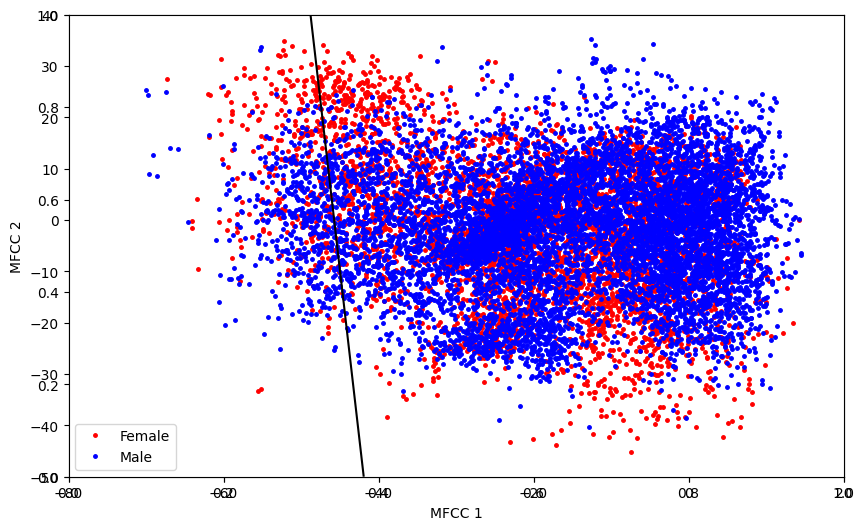

In [10]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np

(rate,sig) = wav.read('./data/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
mfcc_feat_female_2d = mfcc_feat_female[:,1:3] # first 2 dimensions

(rate,sig) = wav.read('./data/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
mfcc_feat_male_2d = mfcc_feat_male[:,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

# fit a LOGIT classifier and get predictions
logit = LogisticRegression()
logit.fit(samples_2d, labels)
logit_labels_pred = logit.predict(samples_2d)

# predict the classification probabilities on a grid
xlim = (-80, 20)
ylim = (-50, 40)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
oned_xx = xx.ravel()
oned_yy = yy.ravel()
Z = logit.predict_proba(np.column_stack((oned_xx,oned_yy)))
Z = Z[:, 1].reshape(xx.shape)
fig, ax_logit = plt.subplots(figsize=(10, 6))
ax_logit = plt.axes()
ax_logit.plot(samples_2d[(labels==0),0], samples_2d[(labels==0),1], '.', ms=5, c='r', label='Female')
ax_logit.plot(samples_2d[(labels==1),0], samples_2d[(labels==1),1], '.', ms=5, c='b', label='Male')
ax_logit.legend(loc=3)
ax_logit.set_xlabel('MFCC 1')
ax_logit.set_ylabel('MFCC 2')

# Now plot the contour between the two classes at p=0.5
# i.e. for every coordinate in xx,yy, if z is at 0.5 
# (equal probability) of both classes, then draw the contour at that coordinate
ax_logit.contour(xx, yy, Z, [0.5], colors='k')

plt.show()

Now that we have built a logistic regression classifier, the next thing to do is to run our standard classifier scoring procedure for completeness and contamination:

In [11]:
# fit a LOGIT classifier and get predictions
logit = LogisticRegression(class_weight='balanced')
logit.fit(samples, labels)
logit_labels_pred = logit.predict(samples)

# get LOGIT scores
completeness_score = recall_score(labels,logit_labels_pred)
contamination_score = (1-precision_score(labels,logit_labels_pred))
print('LOGIT')
print('Completeness: %f'%completeness_score)
print('Contamination: %f'%contamination_score)

LOGIT
Completeness: 0.833130
Contamination: 0.093746


The results so far seem to be the best in terms of contamination, though not the best in terms of completeness. Discriminative classifiers in general are very powerful, and can account for unseen training data more than generative classifiers on average. However, the results on one particular dataset do not guarantee the same kind of performance on any problem out there. That is why it is important to try out different methods for your particular problem to find the best classifier.

## Support Vector Machines
Now let us look at yet another way of choosing a linear decision boundary, which leads off in an entirely different direction, that of <b>support vector machines</b> (SVMs). Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression. In this section, we will develop the intuition behind support vector machines and their use in classification problems.

Consider finding a hyperplane that maximizes the distance of the closest point from either class in the figure below. We call this distance the <b>margin</b>. Points on the margin are called <b>support vectors</b>. Let us begin by assuming the classes are linearly separable. We want to find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.More importantly, we need to find the optimally discriminating line/curve/manifold.

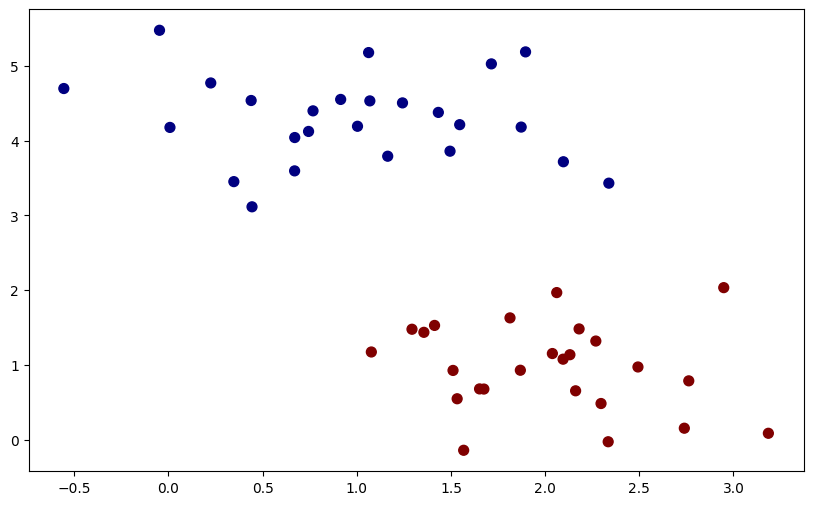

In [12]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

fig, svm1 = plt.subplots(figsize=(10, 6))
svm1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes. We can draw them as follows:

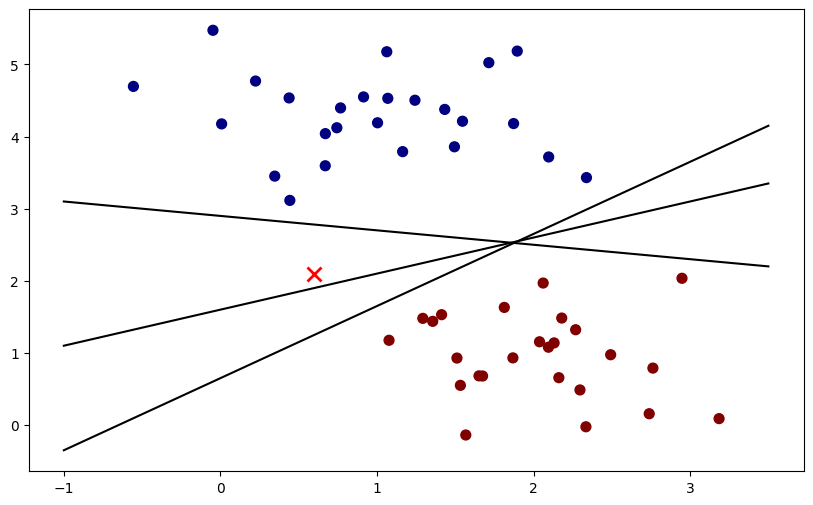

In [13]:
xfit = np.linspace(-1, 3.5)
fig, svm2 = plt.subplots(figsize=(10, 6))
svm2.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
svm2.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    svm2.plot(xfit, m * xfit + b, '-k')
    
plt.show()

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

### Maximizing the Margin
Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

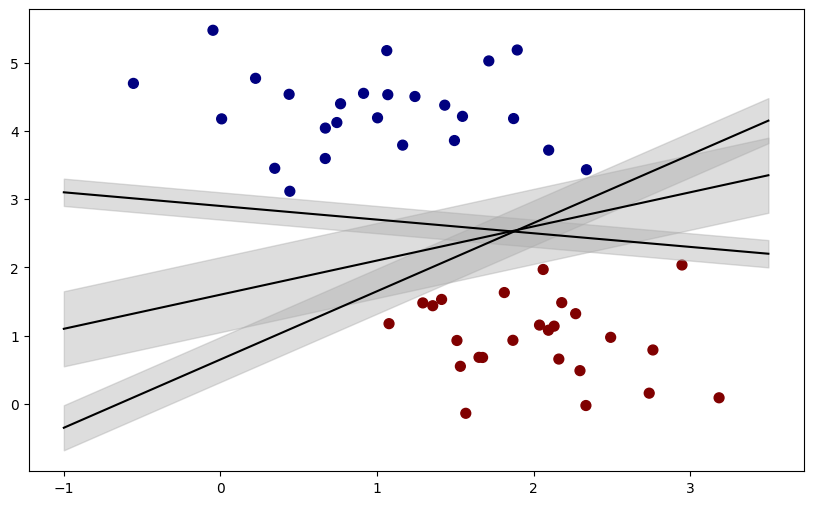

In [14]:
xfit = np.linspace(-1, 3.5)
fig, svm3 = plt.subplots(figsize=(10, 6))
svm3.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    svm3.plot(xfit, yfit, '-k')
    svm3.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a <b>maximum margin estimator</b>.

### Fitting a SVM
Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the C parameter to a very large number (we will discuss the meaning of these in more depth momentarily).

In [15]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

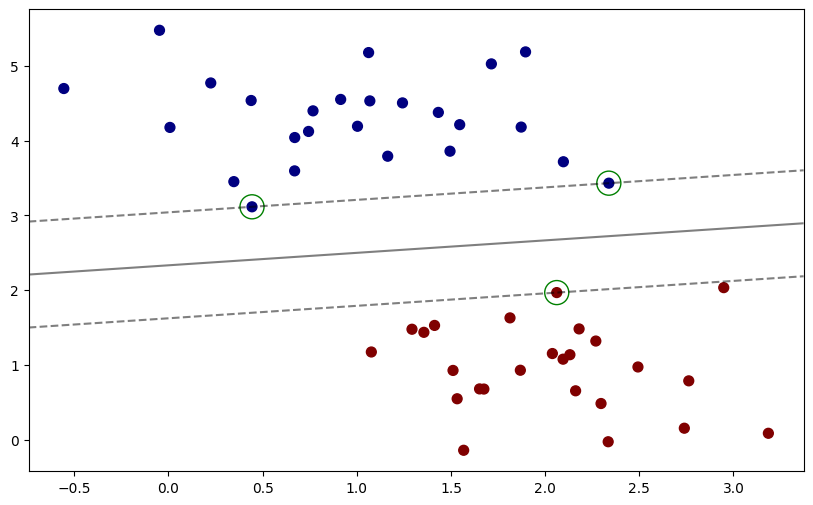

In [16]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='g');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

xfit = np.linspace(-1, 3.5)
fig, svm3 = plt.subplots(figsize=(10, 6))
svm3.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
plot_svc_decision_function(model,ax=svm3);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the green circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the 'support_vectors_' attribute of the classifier:

In [17]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

Let us now see how this linear SVM classifier performs on our Female vs Male voice classification problem.

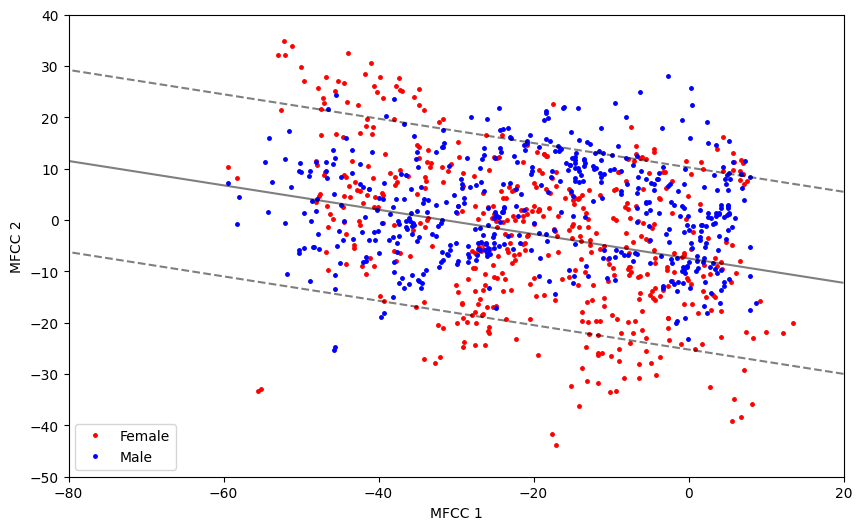

In [18]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np

# Load up dataset
(rate,sig) = wav.read('./data/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
mfcc_feat_female = mfcc_feat_female[0:500,:] # first 500 points
mfcc_feat_female_2d = mfcc_feat_female[0:500,1:3] # first 2 dimensions

(rate,sig) = wav.read('./data/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
mfcc_feat_male = mfcc_feat_male[0:500,:] # first 500 points
mfcc_feat_male_2d = mfcc_feat_male[0:500,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

# fit an SVM classifier, and get predictions too
from sklearn.svm import SVC # "Support vector classifier"
svc_model = SVC(kernel='linear', class_weight='balanced', C=10)
svc_model.fit(samples_2d, labels)
svc_pred = svc_model.predict(samples_2d)

fig, svm4 = plt.subplots(figsize=(10, 6))
xlim = (-80, 20)
ylim = (-50, 40)
svm4.plot(samples_2d[(labels==0),0], samples_2d[(labels==0),1], '.', ms=5, c='r', label='Female')
svm4.plot(samples_2d[(labels==1),0], samples_2d[(labels==1),1], '.', ms=5, c='b', label='Male')
svm4.legend(loc=3)
svm4.set_xlabel('MFCC 1')
svm4.set_ylabel('MFCC 2')
svm4.set_xlim(xlim)
svm4.set_ylim(ylim)
plot_svc_decision_function(svc_model,ax=svm4,plot_support=False);

The classification is not perfect as when we do not clear separation between data points. It is best to evaluate this classifier numerically again, with completeness and contamination factors. We will also include all  dimensions of our dataset for a full result.

In [19]:
completeness_score = recall_score(labels,svc_pred)
contamination_score = (1-precision_score(labels,svc_pred))
print('SVC')
print('Completeness: %f'%completeness_score)
print('Contamination: %f'%contamination_score)

SVC
Completeness: 0.610000
Contamination: 0.462081


The results are average at best, with low completeness and high contamination. SVMs however, can be a lot more powerful than the linear SVM we have considered so far, if we go beyond the restriction of finding a linear boundary between classes.

### Non-Linear (Kernel) SVMs
Where SVM becomes extremely powerful is when it is combined with kernels. The idea of a kernel is a function that projects our data into a higher-dimensional space defined by polynomials and Gaussian basis functions, such that within that higher-dimensional space, there will be a linear separation between the classes - thereby able to fit for nonlinear relationships with a linear classifier. To understand this concept let us look at some data that is not linearly separable:

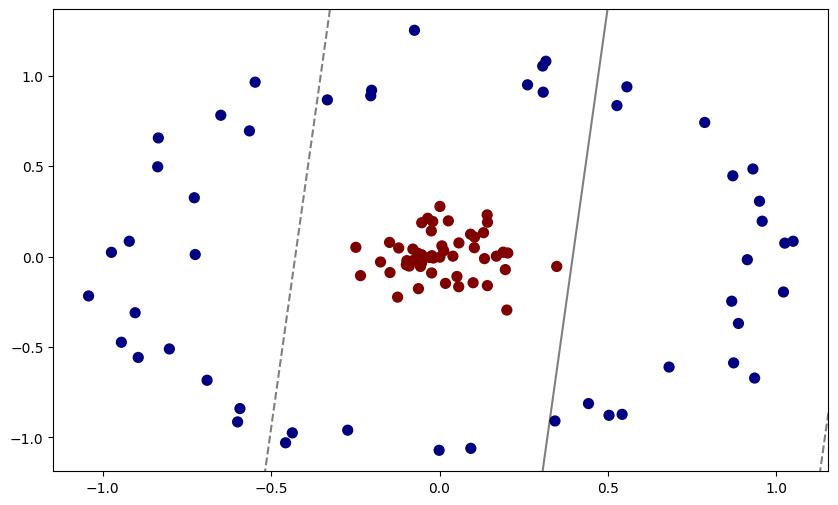

In [20]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

fig, svm5 = plt.subplots(figsize=(10, 6))
svm5.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
plot_svc_decision_function(clf,ax=svm5,plot_support=False);

It is clear that no linear discrimination will ever be able to separate this data. How might we project the data into a higher dimension such that a linear separator would be sufficient? For example, one simple projection we could use would be to compute a radial basis function centered on the middle clump.

A radial basis function (RBF) is a real-valued function whose value depends only on the distance from the origin.

In [21]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot:

C:\Users\User\AppData\Local\Temp\ipykernel_11504\2821445145.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(projection='3d')


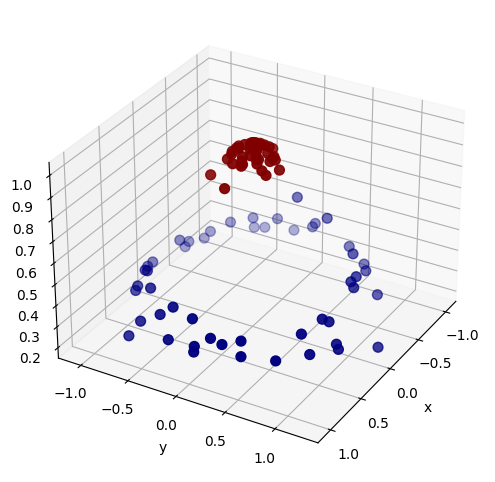

In [22]:
from mpl_toolkits import mplot3d

def plot_3D(X=X, y=y, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], 
                 r, c=y, s=50, cmap='jet')
    ax.view_init(elev=30, azim=30)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

fig, svm6 = plt.subplots(figsize=(10, 6))
plot_3D(X=X, y=y, ax=svm6);

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, r=0.7. Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a <b>kernel transformation</b>, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions is that it might become very computationally intensive as $N$ grows large. However, because of a neat little procedure known as the <b>kernel trick</b>, a fit on kernel-transformed data can be done implicitly — that is, without ever building the full $N$-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful. We can work in the implicit feature space without ever computing the coordinates of the data in that space, but rather by simply computing the inner products between all pairs of samples in the feature space. This operation is often computationally cheaper than the explicit computation of the coordinates. Kernel functions have been introduced for sequence data, graphs, text, images, as well as vectors.

In this simple formulation, one simply replaces each occurrence of $(x_i,x_{i′})$ with a kernel function $K(x_i,x_{i′})$ with certain properties which allow one to think of the SVM as operating in a higher-dimensional space. One such kernel is the Gaussian kernel:

\begin{equation}
K(x_i,x_{i′}) = e^{-\gamma ||x_i-x_{i'}||^2}
\end{equation}


where $\gamma$ is a parameter to be learned via validation testing. In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter:

In [23]:
clf = SVC(kernel='rbf', C=1E6, gamma='auto')
clf.fit(X, y)

SVC(C=1000000.0, gamma='auto')

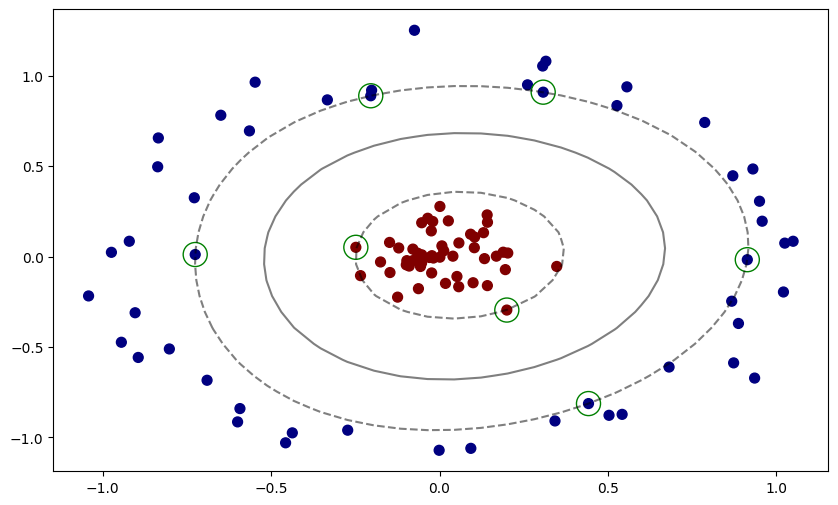

In [24]:
fig, svm7 = plt.subplots(figsize=(10, 6))
svm7.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
plot_svc_decision_function(clf,ax=svm7)

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary. This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used. The next step, as usual, is to try out this method onto our exampe dataset:

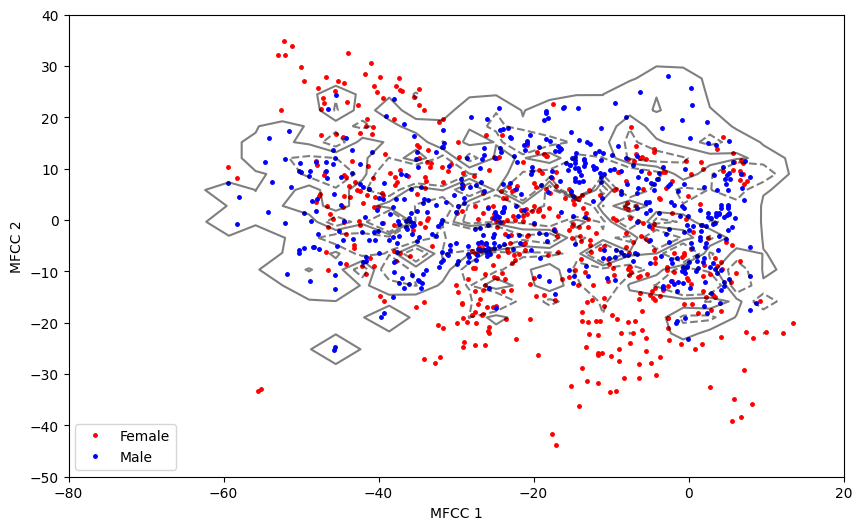

In [25]:
# Load up dataset
(rate,sig) = wav.read('./data/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
mfcc_feat_female = mfcc_feat_female[0:500,:] # first 500 points
mfcc_feat_female_2d = mfcc_feat_female[0:500,1:3] # first 2 dimensions

(rate,sig) = wav.read('./data/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
mfcc_feat_male = mfcc_feat_male[0:500,:] # first 500 points
mfcc_feat_male_2d = mfcc_feat_male[0:500,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

# fit an SVM classifier, and get predictions too
from sklearn.svm import SVC # "Support vector classifier"
svc_model = SVC(kernel='rbf', class_weight='balanced', C=100, gamma='auto')
svc_model.fit(samples_2d, labels)
svc_pred = svc_model.predict(samples_2d)

fig, svm8 = plt.subplots(figsize=(10, 6))
xlim = (-80, 20)
ylim = (-50, 40)
svm8.plot(samples_2d[(labels==0),0], samples_2d[(labels==0),1], '.', ms=5, c='r', label='Female')
svm8.plot(samples_2d[(labels==1),0], samples_2d[(labels==1),1], '.', ms=5, c='b', label='Male')
svm8.legend(loc=3)
svm8.set_xlabel('MFCC 1')
svm8.set_ylabel('MFCC 2')
svm8.set_xlim(xlim)
svm8.set_ylim(ylim)
plot_svc_decision_function(svc_model,ax=svm8,plot_support=False);

And in order to assess the performance of the classifier, we extract completness and contamination scores:

In [26]:
completeness_score = recall_score(labels,svc_pred)
contamination_score = (1-precision_score(labels,svc_pred))
print('SVC - RBF')
print('Completeness: %f'%completeness_score)
print('Contamination: %f'%contamination_score)

SVC - RBF
Completeness: 0.990000
Contamination: 0.019802


This time we get a high completeness compared to the other methods discussed, with a huge increase in completness, and an almost negligible contamination - far better than what we got with a linear SVM. We can say that for this particular data set, the contamination is very much driven by nonlinear effects.

### Tuning the SVM - Softening Margins
Our discussion thus far has centered around how an SVM works, and trying the variants out on our sample Gender-ID dataset. But what if the method does not work, at least initially? There are ways to tune the SVM, relaxing some of the constraints. Let us look at some simple data with a hypothetical overlap:

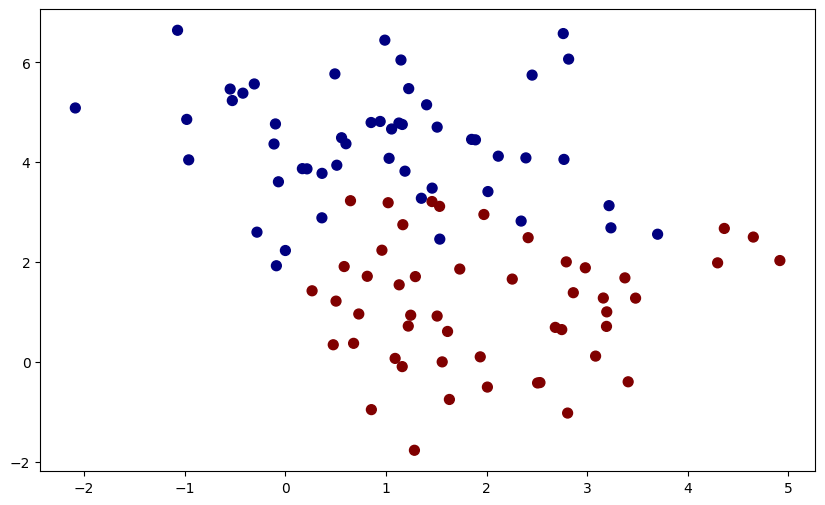

In [27]:
fig, svm9 = plt.subplots(figsize=(10, 6))
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
svm9.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as $C$. For very large $C$, the margin is hard, and points cannot lie in it. For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

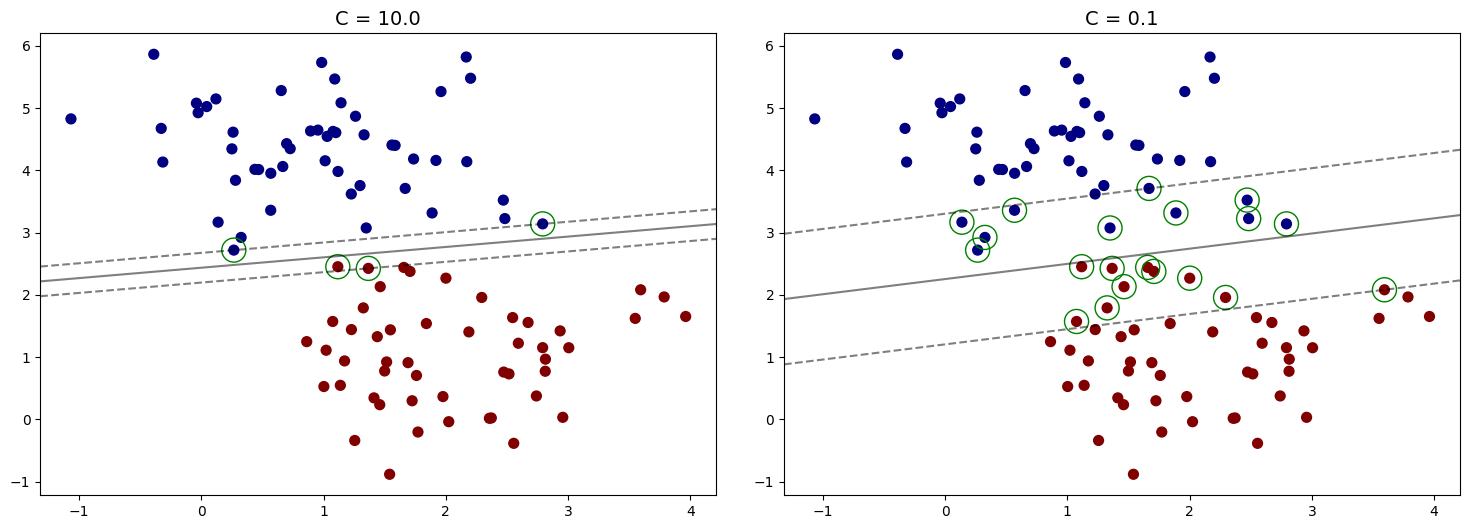

In [28]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure. Let us try and assess the classifier performance on our dataset based on different values of $C$:

In [29]:
from sklearn.svm import SVC # "Support vector classifier"

# Load up dataset
(rate,sig) = wav.read('./data/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
mfcc_feat_female = mfcc_feat_female[0:500,:] # first 500 points
mfcc_feat_female_2d = mfcc_feat_female[0:500,1:3] # first 2 dimensions

(rate,sig) = wav.read('./data/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
mfcc_feat_male = mfcc_feat_male[0:500,:] # first 500 points
mfcc_feat_male_2d = mfcc_feat_male[0:500,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

for c_value in [1,10,100]:
    # fit an SVM classifier, and get predictions too
    svc_model = SVC(kernel='rbf', class_weight='balanced', C=c_value, gamma='auto')
    svc_model.fit(samples_2d, labels)
    svc_pred = svc_model.predict(samples_2d)

    completeness_score = recall_score(labels,svc_pred)
    contamination_score = (1-precision_score(labels,svc_pred))
    print('SVC - RBF: C={0:.1f}'.format(c_value))
    print('Completeness: %f'%completeness_score)
    print('Contamination: %f'%contamination_score)

SVC - RBF: C=1.0
Completeness: 0.860000
Contamination: 0.081197
SVC - RBF: C=10.0
Completeness: 0.934000
Contamination: 0.043033
SVC - RBF: C=100.0
Completeness: 0.990000
Contamination: 0.019802


### Overfitting
You can observe that as $C$ is getting higher, the contamination is decreased. This is a good thing - but be careful not to be too strict, as it may have the adverse effect of learning an SVM classifier that is too intrinsically tied to the data used for training - whilst not generalizing well for future data. This phenomenon is called <b>overfitting</b>. One way to test for overfitting for SVM classifiers, and indeed for all the classifiers we have seen so far (and all other classifiers you will work on), is to split your data into two chunks. The first chunk will be called your <b>training set</b> whilst the second chunk will be called your <b>validation set</b>. The validation set will therefore contain data that the classifier never 'saw' during training, and will therefore be very similar to what the classifier might encounter when being utilised for inference. If you notices that your training completeness/contamination scores are very good for your training set but get visibly wors during verification, then you can expect the same bad results to occur during inference. This is usually a sign of ovefitting.

### SVM Summary
We have seen here a brief intuitive introduction to the principals behind support vector machines. These methods are a powerful classification method for a number of reasons:

* Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
* Once the model is trained, the prediction phase is very fast.
* Because they are affected only by points near the margin, they work well with high-dimensional data - even data with more dimensions than samples, which is a challenging regime for other algorithms.
* Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

* The scaling with the number of samples $N$ is $\mathcal{O}(N^3)$ at worst, or $\mathcal{O}(N^2)$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
* The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
* The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the probability parameter of SVC), but this extra estimation is costly.

With those traits in mind, you should generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for your needs. Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

## Decision Trees and Random Forests
Previously we have looked in depth at a simple generative classifier (naive Bayes) and a powerful discriminative classifier (support vector machines). Here we'll take a look at motivating another powerful algorithm — a non-parametric algorithm called random forests. Random forests are an example of an ensemble method, meaning that it relies on aggregating the results of an ensemble of simpler estimators. The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting! We will see examples of this in the following sections.

### Motivation for Random Forests: Decision Trees
Random forests are an example of an <b>ensemble learner</b> built on decision trees. For this reason we shall start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification. For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

<img src="./figures/dec_tree.png" width="800">

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes. The trick, of course, comes in deciding which questions to ask at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features. Let's now look at an example of this.

### Your First Decision Tree
Consider the following two-dimensional data, which has one of four class labels:

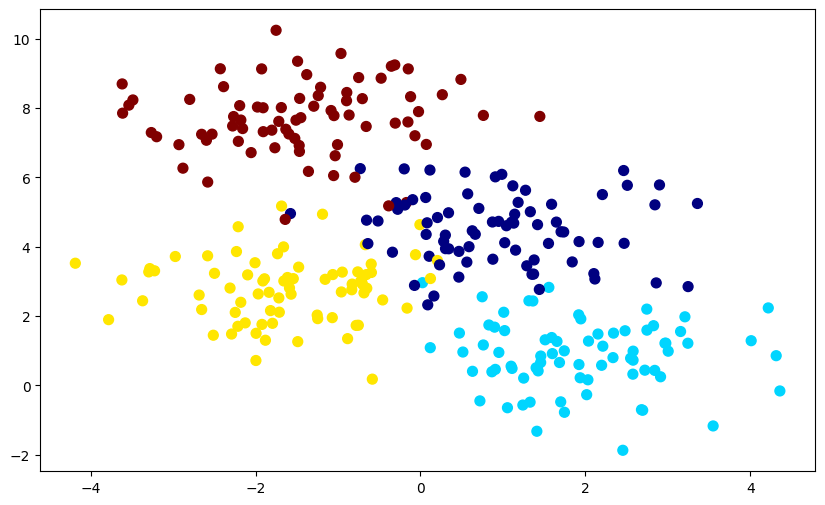

In [30]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
fig, dt1 = plt.subplots(figsize=(10, 6))
dt1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. Let us look into how a decision tree may split this data at various iteration steps:

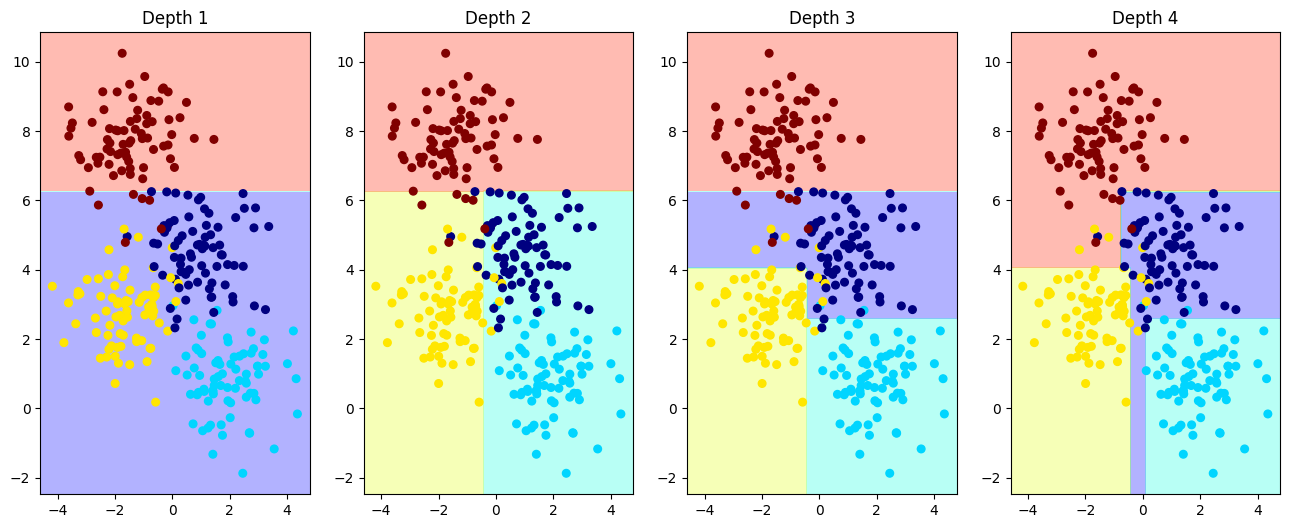

In [31]:
from sklearn.tree import DecisionTreeClassifier

# A nice utility function that will help us visualize a Decision Tree classifier
def visualize_classifier(model, X, y, ax=None, cmap='jet'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    # ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
#                            cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)


f, axes_depths = plt.subplots(1, 4, figsize=(16, 6))
for depth in [1,2,3,4]:
    tree = DecisionTreeClassifier(max_depth=depth)
    visualize_classifier(model=tree,X=X,y=y,ax=axes_depths[depth-1])
    axes_depths[depth-1].set_title('Depth {0:d}'.format(depth))

plt.show()

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch. Except for nodes that contain all of one color, at each level every region is again split along one of the two features.

Now what if we keep splitting further (increasing the tree depth)? Let's have a look:

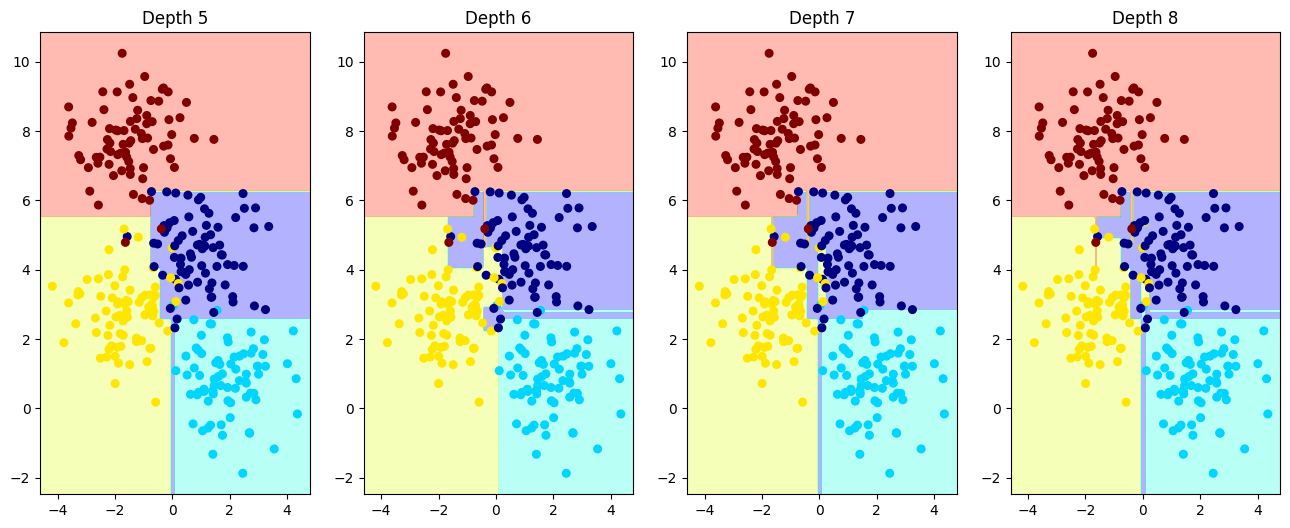

In [32]:
f, axes_depths2 = plt.subplots(1, 4, figsize=(16, 6))
for depth in [1,2,3,4]:
    tree = DecisionTreeClassifier(max_depth=depth+4)
    visualize_classifier(model=tree,X=X,y=y,ax=axes_depths2[depth-1])
    axes_depths2[depth-1].set_title('Depth {0:d}'.format(depth+4))

plt.show()

Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions. It is clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data. That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

### Decision Trees and Overfitting
Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from. Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

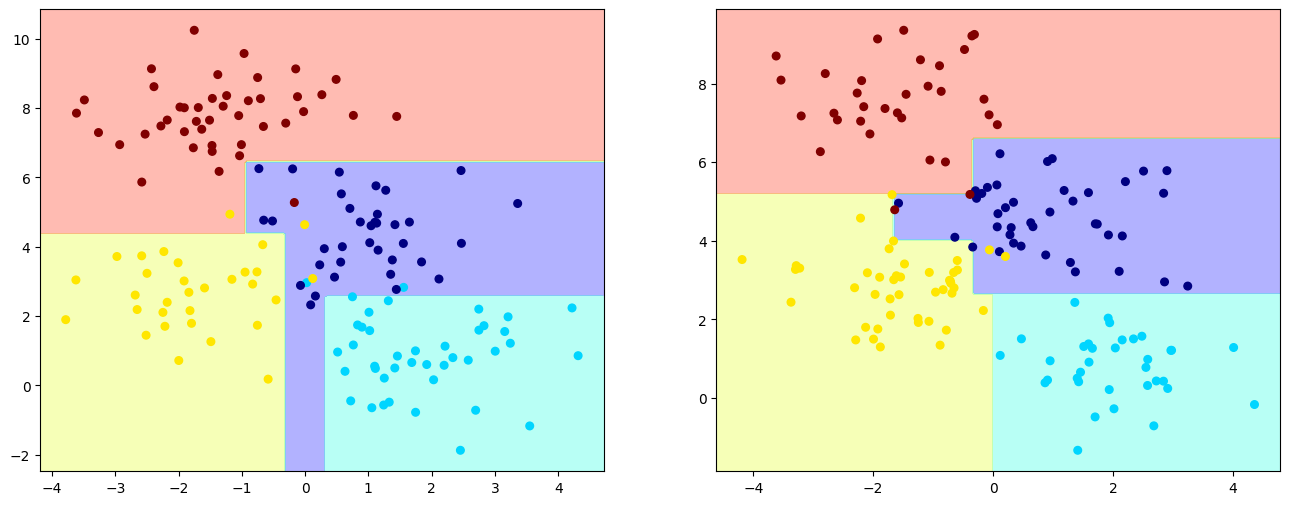

In [33]:
f, dt2 = plt.subplots(1, 2, figsize=(16, 6))
tree = DecisionTreeClassifier(max_depth=4)
visualize_classifier(model=tree, X=X[::2], y=y[::2], ax=dt2[0])
visualize_classifier(model=tree, X=X[1::2], y=y[1::2], ax=dt2[1])
plt.show()

It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters). The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from both of these trees, we might come up with a better result.

Now that we have an intuition of decision trees, let us try out a decision tree classifier on our Gender-ID dataset:

In [34]:
# Load up dataset
(rate,sig) = wav.read('./data/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
mfcc_feat_female = mfcc_feat_female[0:500,:] # first 500 points
mfcc_feat_female_2d = mfcc_feat_female[0:500,1:3] # first 2 dimensions

(rate,sig) = wav.read('./data/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
mfcc_feat_male = mfcc_feat_male[0:500,:] # first 500 points
mfcc_feat_male_2d = mfcc_feat_male[0:500,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

for depth in [1,2,3,4,5]:
    tree = DecisionTreeClassifier(max_depth=depth,class_weight='balanced').fit(samples,labels)
    tree_pred = tree.predict(samples)
    
    completeness_score = recall_score(labels,tree_pred)
    contamination_score = (1-precision_score(labels,tree_pred))
    print('Decision Tree: Depth {0:d}'.format(depth))
    print('Completeness: %f'%completeness_score)
    print('Contamination: %f'%contamination_score)

Decision Tree: Depth 1
Completeness: 0.356000
Contamination: 0.114428
Decision Tree: Depth 2
Completeness: 0.902000
Contamination: 0.327869
Decision Tree: Depth 3
Completeness: 0.930000
Contamination: 0.248788
Decision Tree: Depth 4
Completeness: 0.942000
Contamination: 0.182292
Decision Tree: Depth 5
Completeness: 0.970000
Contamination: 0.173765


The completeness score increases with tree depth, and the contamination is decreasing. This is a very good result on our dataset. However keep in mind that like in all other demonstrations before, we are predicting the class of data points which were seen during training. In reality this will never be the case (we only proceeded this way for brevity). But for the sake of showing how the performance of a decision tree varies when this is not so, let us re-run this experiment, this time splitting the data into two sets: training and validation (the same technique can be used in all other experiments):

In [35]:
from sklearn.model_selection import train_test_split

# Load up dataset
(rate,sig) = wav.read('./data/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
mfcc_feat_female = mfcc_feat_female[0:500,:] # first 500 points
mfcc_feat_female_2d = mfcc_feat_female[0:500,1:3] # first 2 dimensions

(rate,sig) = wav.read('./data/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
mfcc_feat_male = mfcc_feat_male[0:500,:] # first 500 points
mfcc_feat_male_2d = mfcc_feat_male[0:500,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))
samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

# keep 33% of the data for testing/validation
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.33)

for depth in [1,2,3,4,5]:
    tree = DecisionTreeClassifier(max_depth=depth,class_weight='balanced').fit(X_train,y_train)
    tree_pred = tree.predict(X_test)
    
    completeness_score = recall_score(y_test,tree_pred)
    contamination_score = (1-precision_score(y_test,tree_pred))
    print('Decision Tree: Depth {0:d}'.format(depth))
    print('Completeness: %f'%completeness_score)
    print('Contamination: %f'%contamination_score)

Decision Tree: Depth 1
Completeness: 0.981595
Contamination: 0.446367
Decision Tree: Depth 2
Completeness: 0.343558
Contamination: 0.125000
Decision Tree: Depth 3
Completeness: 0.828221
Contamination: 0.347826
Decision Tree: Depth 4
Completeness: 0.662577
Contamination: 0.205882
Decision Tree: Depth 5
Completeness: 0.858896
Contamination: 0.259259


The scores change slightly - primarily completeness hits a bit of a wall around a depth of 3 and goes back down after that. Contamination improves along all depths, but overall, a smaller training set results in worse (albeit more realistic) results.

In principle, the recursive splitting of the tree could continue until there is a single point per node. This is, however, inefficient as it results in $\mathcal{O}(N)$ computational cost for both the construction and traversal of the tree. A common criterion for stopping the recursion is, therefore, to cease splitting the nodes when either a node contains only one class of object, when a split does not improve the information gain or reduce the misclassifications, or when the number of points per node reaches a predefined value.

As with all model fitting, as we increase the complexity of the model we run into the issue of overfitting the data. For decision trees the complexity is defined by the number of levels or depth of the tree. As the depth of the tree increases, the error on the training set will decrease. At some point, however, the tree will cease to represent the correlations within the data and will reflect the noise within the training set. We can, therefore, use some cross-validation techniques (multiple train/validation data splits) and observe the overall misclassification error to optimize the depth of the tree.

### Ensembles of Estimators
The notion that overfitting estimators can be combined to reduce the effect of this overfitting is what underlies an ensemble method called <b>bagging</b>. Bagging (from bootstrap aggregation) averages the predictive results of a series of bootstrap samples from a training set of data. Often applied to decision trees, bagging is applicable to regression and many nonlinear model fitting or classification techniques. For a sample of $N$ points in a training set, bagging generates $K$ equally sized bootstrap samples from which to estimate the function $f_i(x)$. The final estimator, defined by bagging, is then:

\begin{equation}
f(x) = \frac{1}{K}\sum_{i}^{K}f_i(x)
\end{equation}

Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.

<b>Random forests</b> expand upon the bootstrap aspects of bagging by generating a set of decision trees from these bootstrap samples. The features on which to generate the tree are selected at random from the full set of features in the data. The final classification from the random forest is based on the averaging of the classifications of each of the individual decision trees. In so doing, random forests address two limitations of decision trees: the overfitting of the data if the trees are inherently deep, and the fact that axis-aligned partitioning of the data does not accurately reflect the potentially correlated and/or nonlinear decision boundaries that exist within data sets.

In generating a random forest we define $n$, the number of trees that we will generate, and $m$, the number of attributes that we will consider splitting on at each level of the tree. For each decision tree a subsample (bootstrap sample) of data is selected from the full data set. At each node of the tree, a set of $m$ variables are randomly selected and the split criteria is evaluated for each of these attributes; a different set of $m$ attributes are used for each node. The classification is derived from the mean or mode of the results from all of the trees. Keeping $m$ small compared to the number of features controls the complexity of the model and reduces the concerns of overfitting.

We can create this type of bagging classification using Scikit-Learn's BaggingClassifier estimator, as shown here:

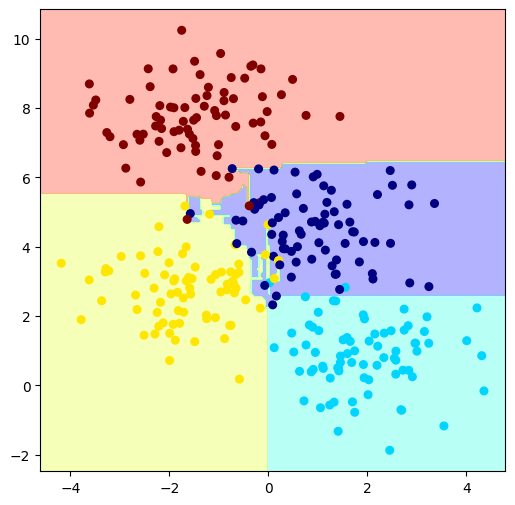

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100,
                        max_samples=0.8,
                        random_state=1)

bag.fit(X, y)

f, dt3 = plt.subplots(figsize=(6, 6))
visualize_classifier(bag, X, y)
plt.show()

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness. For example, when determining which feature to split on, the randomized tree might select from among the top several features. You can read more technical details about these randomization strategies in the Scikit-Learn documentation and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the RandomForestClassifier estimator, which takes care of all the randomization automatically. All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

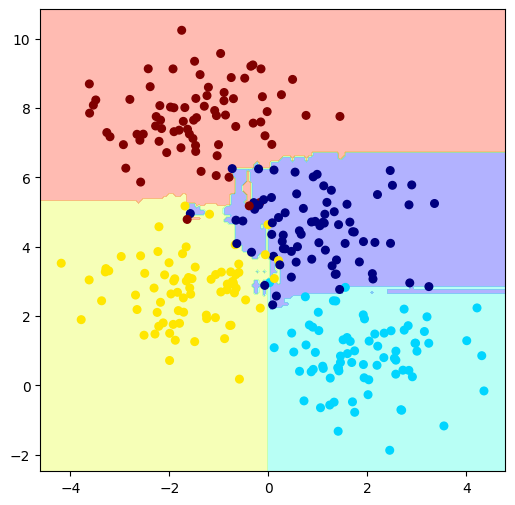

In [37]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)

f, dt4 = plt.subplots(figsize=(6, 6))
visualize_classifier(model, X, y)
plt.show()

We see that by averaging over 100 random models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

Similar to the cross-validation technique used to arrive at the optimal depth of the tree, cross-validation can also be used to determine the number of trees, $n$, and the number of random features $m$, simply by optimizing over all free parameters. With random forests, $n$ is typically increased until the cross-validation error plateaus, and $\sqrt{m}$ is often chosen to be $∼ K$ , where $K$ is the number of attributes in the sample.

# Classifier Evaluation - ROC Curves
Comparing the performance of classifiers is an important part of choosing the best classifier for a given task. "Best" in this case can be highly subjective: for some problems, one might wish for high completeness at the expense of contamination; at other times, one might wish to minimize contamination at the expense of completeness. One way to visualize this is to plot receiver operating characteristic (ROC) curves. An ROC curve usually shows the true-positive rate as a function of the false-positive rate as the discriminant function is varied. How the function is varied depends on the model: in the example of Gaussian naive Bayes, the curve is drawn by classifying data using relative probabilities between 0 and 1.

Let us look at how to generate and interpret ROC curves. Scikit-learn has some built-in tools for computing ROC curves and completeness–efficiency curves (known as precision-recall curves in the machine learning community). We shall be using most of the stuff we learnt throughout this topic in this final example - classifiers, data handling, data splits, plotting tricks, etc.:

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

In [39]:


# Load up dataset
(rate,sig) = wav.read('./data/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
#mfcc_feat_female = mfcc_feat_female[0:2000,:] # first 2000 points
mfcc_feat_female_2d = mfcc_feat_female[:,1:3] # first 2 dimensions

(rate,sig) = wav.read('./data/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
#mfcc_feat_male = mfcc_feat_male[0:2000,:] # first 2000 points
mfcc_feat_male_2d = mfcc_feat_male[:,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

# split into training and test sets
# keep 10% of the data for testing/validation
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.1)


# Show sample data on left axis
f, (roc1, roc2) = plt.subplots(1, 2, figsize=(16, 6))
roc1.plot(samples_2d[(labels==0),0], samples_2d[(labels==0),1], '.', ms=5, c='r', label='Female')
roc1.plot(samples_2d[(labels==1),0], samples_2d[(labels==1),1], '.', ms=5, c='b', label='Male')
xlim = (-80, 20)
ylim = (-50, 40)
roc1.set_xlabel('MFCC 1')
roc1.set_ylabel('MFCC 2')
roc1.set_xlim(xlim)
roc1.set_ylim(ylim)
roc1.legend(loc="upper right")


## Run fits for all classifiers
names = []
probs = []

# Fit the Naive Bayes classifier and store test results
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_prob = gnb.predict_proba(X_test)
names.append('GaussianNB')
probs.append(y_prob[:, 1])

# Fit the LDA classifier and store test results
lda = LDA()
lda.fit(X_train, y_train)
y_prob = lda.predict_proba(X_test)
names.append('LDA')
probs.append(y_prob[:, 1])

# Fit the QDA classifier and store test results
qda = QDA()
qda.fit(X_train, y_train)
y_prob = qda.predict_proba(X_test)
names.append('QDA')
probs.append(y_prob[:, 1])

# Fit the Logistic Regression classifier and store test results
logit = LogisticRegression(class_weight='balanced',solver='lbfgs')
logit.fit(X_train, y_train)
y_prob = logit.predict_proba(X_test)
names.append('Logit')
probs.append(y_prob[:, 1])

# SVM Training will take a while, uncomment to add to results
# Fit a linear SVM classifier and store test results
svc_model = SVC(kernel='linear', class_weight='balanced', C=10, probability=True)
svc_model.fit(X_train, y_train)
y_prob = svc_model.predict_proba(X_test)
names.append('SVC-Linear')
probs.append(y_prob[:, 1])

# Fit an RBF SVM classifier and store test results
svc_model = SVC(kernel='rbf', class_weight='balanced', C=10, gamma='auto', probability=True)
svc_model.fit(X_train, y_train)
y_prob = svc_model.predict_proba(X_test)
names.append('SVC-RBF')
probs.append(y_prob[:, 1])

# Fit Decision Tree ensemble classifier and store test results
tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=30, max_samples=0.8, random_state=1)
bag.fit(X_train, y_train)
y_prob = bag.predict_proba(X_test)
names.append('Tree Ensemble')
probs.append(y_prob[:, 1])

for i in range(0,len(names)):
    classifier = names[i]
    y_prob = probs[i]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    roc2.plot(fpr, tpr, label=classifier)

roc2.legend(loc=4)
roc2.set_xlabel('False Positive Rate')
roc2.set_ylabel('True Positive Rate')
roc2.set_xlim(0, 1.0)
roc2.set_ylim(0, 1.01)

plt.show()

Interpreting an ROC curve is easy. We are aiming to maximize the true positive rate, and to minimize the false positive rate. That means that the curves closest to the upper left of the plot are the best classifiers. In our exampe therefore, the best classifiers would be the Tree Ensemble and RBF Kernel SVM. Other classifiers seem to reach the same true positive rates at much higher false positive rates. These simpler classifiers, whilst useful in some situations, do not adequately explain these MFCC data for our problem. GaussianNB, especially, performs worst. These results will not be the same for every problem and therefore such an evaulation is important for most cases. There is no rule of thumb.